# Experiment 5: Pseudo-Label Threshold Ablation (Target Rare Classes)

This experiment quantifies how pseudo-label quality vs quantity affects domain adaptation performance by testing different confidence thresholds.

## Objective

- Test whether relaxing the confidence threshold can improve rare / currently-zero F1 classes (especially tomato diseases)
- Determine optimal balance between pseudo-label quality (precision) and quantity (coverage)
- Maintain PlantVillage performance while improving Field performance

## Thresholds to Test

- **T=0.95**: High precision, low coverage (strictest)
- **T=0.90**: Reference point (from Experiment 4)
- **T=0.85**: Higher coverage, more noise (more relaxed)

## Fixed Rules (Same as Experiment 4)

- Same splits: PlantVillage train/val/test, Field Test set, Field-Unlabeled pool
- Same architecture and training recipe
- Student initialized from teacher
- 70% PV / 30% pseudo-field sampling
- Student LR = 1e-4, max epochs = 15
- **Only variable that changes: confidence threshold T**


## Imports and Setup


In [1]:
# Imports and Setup
import os
import time
import copy
from pathlib import Path
from collections import Counter, defaultdict
import json
import csv

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.amp import autocast, GradScaler

from PIL import Image
import torchvision.transforms as T
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import timm
from sklearn.metrics import f1_score, classification_report, confusion_matrix

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Mixed precision support
USE_AMP = torch.cuda.is_available() and hasattr(torch.cuda, 'amp')
print(f"Mixed Precision (AMP): {'Enabled' if USE_AMP else 'Disabled'}")

# Paths
current_dir = Path(os.getcwd())

if current_dir.name == "experiment_5_threshold_ablation":
    BASE_DIR = current_dir.parent
else:
    BASE_DIR = current_dir

METADATA_DIR = BASE_DIR / "metadata"
LABEL_MAPPING_PATH = METADATA_DIR / "label_mapping.json"
DATASET_INDEX_PATH = METADATA_DIR / "dataset_index.json"
DATA_DIR = BASE_DIR / "data"
FIELDPLANT_DIR = DATA_DIR / "FieldPlant_reformatted"

MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

EXPERIMENT_DIR = BASE_DIR / "experiment_5_threshold_ablation"
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

# Experiment 4 directory (to load T=0.90 results)
EXPERIMENT_4_DIR = BASE_DIR / "experiment_4"

print(f"Current working directory: {current_dir}")
print(f"Base directory: {BASE_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Experiment directory: {EXPERIMENT_DIR}")


C:\Users\Kero\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Mixed Precision (AMP): Enabled
Current working directory: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_5_threshold_ablation
Base directory: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION
Models directory: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\models
Experiment directory: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_5_threshold_ablation


## Step 0: Load Metadata and Set Up Data Splits (Same as Experiment 4)


In [2]:
# Load main dataset metadata
with open(LABEL_MAPPING_PATH, "r") as f:
    label_mapping = json.load(f)

with open(DATASET_INDEX_PATH, "r") as f:
    dataset_index = json.load(f)

# Create mappings
id_to_label = {c["id"]: c["canonical_label"] for c in label_mapping["classes"]}
label_to_id = {v: k for k, v in id_to_label.items()}

num_classes = len(label_mapping["classes"])
print(f"Main dataset: {num_classes} classes")

# FieldPlant to canonical label mapping (same as Experiment 3/4)
fieldplant_to_canonical = {
    "Corn___Gray_leaf_spot": "corn_cercospora_leaf_spot_gray_leaf_spot",
    "Corn___rust_leaf": "corn_common_rust",
    "Corn___leaf_blight": "corn_northern_leaf_blight",
    "Corn___healthy": "corn_healthy",
    "Tomato___healthy": "tomato_healthy",
    "Tomato___leaf_mosaic_virus": "tomato_tomato_mosaic_virus",
    "Tomato___leaf_yellow_virus": "tomato_tomato_yellow_leaf_curl_virus",
}

# Find intersection classes
fieldplant_classes = set(fieldplant_to_canonical.values())
pv_classes = set(id_to_label.values())
intersection_classes = fieldplant_classes.intersection(pv_classes)

print(f"\nIntersection classes (PV ∩ FieldPlant): {len(intersection_classes)}")
for cls in sorted(intersection_classes):
    print(f"  - {cls}")


Main dataset: 39 classes

Intersection classes (PV ∩ FieldPlant): 7
  - corn_cercospora_leaf_spot_gray_leaf_spot
  - corn_common_rust
  - corn_healthy
  - corn_northern_leaf_blight
  - tomato_healthy
  - tomato_tomato_mosaic_virus
  - tomato_tomato_yellow_leaf_curl_virus


In [3]:
# Load PlantVillage data (same splits as Experiment 4)
train_entries_pv = [e for e in dataset_index if e["split"] == "train"]
val_entries_pv = [e for e in dataset_index if e["split"] == "val"]
test_entries_pv = [e for e in dataset_index if e["split"] == "test"]

print(f"PlantVillage training samples: {len(train_entries_pv)}")
print(f"PlantVillage validation samples: {len(val_entries_pv)}")
print(f"PlantVillage test samples: {len(test_entries_pv)}")

# Load FieldPlant data and split (same as Experiment 4 - use same random seed)
def load_fieldplant_data(data_dir, intersection_classes_only=True):
    """Load FieldPlant dataset entries."""
    entries = []
    if not data_dir.exists():
        print(f"Warning: {data_dir} does not exist!")
        return entries
    
    for folder in data_dir.iterdir():
        if not folder.is_dir():
            continue
        canonical = fieldplant_to_canonical.get(folder.name)
        if canonical is None:
            continue
        if intersection_classes_only and canonical not in intersection_classes:
            continue
        if canonical not in label_to_id:
            continue
        
        class_id = label_to_id[canonical]
        image_files = list(folder.glob("*.jpg")) + list(folder.glob("*.JPG"))
        for img_path in image_files:
            entries.append({
                "path": str(img_path),
                "class_id": class_id,
                "dataset": "fieldplant",
                "canonical_label": canonical
            })
    return entries

# Load and split field data (same seed as Experiment 4 for reproducibility)
all_field_entries = load_fieldplant_data(FIELDPLANT_DIR, intersection_classes_only=True)
np.random.seed(42)  # Same seed as Experiment 4
indices = np.arange(len(all_field_entries))
np.random.shuffle(indices)

test_size = int(len(all_field_entries) * 0.2)
test_indices = indices[:test_size]
unlabeled_indices = indices[test_size:]

test_entries_field = [all_field_entries[i] for i in test_indices]
unlabeled_entries_field = [all_field_entries[i] for i in unlabeled_indices]

print(f"\nField Test Set: {len(test_entries_field)} samples")
print(f"Field Unlabeled Pool: {len(unlabeled_entries_field)} samples")


PlantVillage training samples: 49179
PlantVillage validation samples: 6148
PlantVillage test samples: 6159

Field Test Set: 928 samples
Field Unlabeled Pool: 3712 samples


## Step 0 (continued): Define Transforms and Dataset Class


In [4]:
# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMG_SIZE = 224

# Baseline augmentation (for PV data)
transform_baseline_train = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Lighter augmentation for pseudo-labeled field data
transform_pseudo_field_train = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Evaluation transform
transform_eval = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Dataset class
class PlantDataset(Dataset):
    def __init__(self, entries, transform_train=None, transform_eval=None, base_dir=None):
        self.entries = entries
        self.transform_train = transform_train
        self.transform_eval = transform_eval
        self.base_dir = base_dir or BASE_DIR

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        item = self.entries[idx]
        img_path = item["path"]
        class_id = item["class_id"]

        if not Path(img_path).is_absolute():
            img_path = self.base_dir / img_path
        else:
            img_path = Path(img_path)

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            img = Image.new("RGB", (224, 224), (0, 0, 0))
            class_id = 0

        if self.transform_train is not None:
            img = self.transform_train(img)
        elif self.transform_eval is not None:
            img = self.transform_eval(img)
        else:
            img = transform_eval(img)

        return img, class_id

print("✓ Transforms and dataset class defined")


✓ Transforms and dataset class defined


## Step 0 (continued): Load Teacher Model (Same as Experiment 4)


In [5]:
# Load teacher model (same as Experiment 4)
teacher_checkpoint_path = MODELS_DIR / "efficientnet_b0_baseline_aug.pt"

if not teacher_checkpoint_path.exists():
    # Try alternative location
    teacher_checkpoint_path = MODELS_DIR / "efficientnet_b0_teacher.pt"

if teacher_checkpoint_path.exists():
    print(f"Loading teacher model from: {teacher_checkpoint_path}")
    checkpoint = torch.load(teacher_checkpoint_path, map_location=DEVICE, weights_only=False)
    teacher_model = timm.create_model(
        checkpoint["model_name"],
        pretrained=False,
        num_classes=num_classes
    )
    teacher_model.load_state_dict(checkpoint["state_dict"])
    teacher_model.to(DEVICE)
    teacher_model.eval()
    print(f"✓ Teacher model loaded (best val F1: {checkpoint.get('best_val_f1', 'N/A'):.4f})")
else:
    raise FileNotFoundError(f"Teacher model not found. Please run Experiment 3 or 4 first.")


Loading teacher model from: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\models\efficientnet_b0_baseline_aug.pt
✓ Teacher model loaded (best val F1: 0.9898)


## Step 1 & 2: Generate Pseudo-Labels for Each Threshold

Generate pseudo-labels for T=0.95 and T=0.85. We'll use T=0.90 from Experiment 4 as reference.


In [6]:
# Define thresholds to test
THRESHOLDS = [0.95, 0.85]  # 0.90 will be loaded from Experiment 4
print(f"Testing thresholds: {THRESHOLDS} (plus T=0.90 from Experiment 4)")

# Create dataset for unlabeled field images
unlabeled_dataset = PlantDataset(
    unlabeled_entries_field,
    transform_train=None,
    transform_eval=transform_eval
)

unlabeled_loader = DataLoader(
    unlabeled_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nUnlabeled field images: {len(unlabeled_entries_field)}")

# Generate all pseudo-labels first (we'll filter by threshold later)
print("\nGenerating pseudo-labels with teacher model...")
teacher_model.eval()
all_pseudo_labels = []

with torch.no_grad():
    for batch_idx, (images, _) in enumerate(unlabeled_loader):
        images = images.to(DEVICE)
        
        if USE_AMP:
            with autocast(device_type='cuda'):
                outputs = teacher_model(images)
        else:
            outputs = teacher_model(images)
        
        probs = torch.softmax(outputs, dim=1)
        confidences, predicted_classes = torch.max(probs, dim=1)
        
        for i in range(len(images)):
            idx = batch_idx * 32 + i
            if idx < len(unlabeled_entries_field):
                all_pseudo_labels.append({
                    "image_path": unlabeled_entries_field[idx]["path"],
                    "pseudo_label": predicted_classes[i].item(),
                    "confidence": confidences[i].item()
                })
        
        if (batch_idx + 1) % 50 == 0:
            print(f"  Processed {batch_idx + 1}/{len(unlabeled_loader)} batches")

print(f"✓ Generated {len(all_pseudo_labels)} pseudo-labels")


Testing thresholds: [0.95, 0.85] (plus T=0.90 from Experiment 4)

Unlabeled field images: 3712

Generating pseudo-labels with teacher model...
  Processed 50/116 batches
  Processed 100/116 batches
✓ Generated 3712 pseudo-labels


In [7]:
# Filter by each threshold and save CSV files
pseudo_label_stats = {}

for threshold in THRESHOLDS:
    print(f"\n{'='*70}")
    print(f"Processing threshold T={threshold:.2f}")
    print(f"{'='*70}")
    
    # Filter by threshold
    filtered_pseudo_labels = [
        pl for pl in all_pseudo_labels if pl["confidence"] >= threshold
    ]
    
    # Statistics
    total = len(all_pseudo_labels)
    kept = len(filtered_pseudo_labels)
    retention_rate = (kept / total * 100) if total > 0 else 0.0
    
    pseudo_label_stats[threshold] = {
        "total": total,
        "kept": kept,
        "retention_rate": retention_rate,
        "pseudo_labels": filtered_pseudo_labels
    }
    
    print(f"Total pseudo-labels: {total}")
    print(f"High-confidence (≥{threshold}): {kept} ({retention_rate:.2f}%)")
    
    # Per-class counts
    class_counts = Counter(pl["pseudo_label"] for pl in filtered_pseudo_labels)
    print(f"\nPer-class pseudo-label counts (threshold={threshold}):")
    for class_id, count in sorted(class_counts.items()):
        class_name = id_to_label[class_id]
        print(f"  {class_name}: {count}")
    
    # Focus on tomato classes
    tomato_classes = ["tomato_healthy", "tomato_tomato_mosaic_virus", "tomato_tomato_yellow_leaf_curl_virus"]
    print(f"\nTomato classes (target rare classes):")
    for tomato_class in tomato_classes:
        if tomato_class in label_to_id:
            class_id = label_to_id[tomato_class]
            count = class_counts.get(class_id, 0)
            print(f"  {tomato_class}: {count}")
    
    # Save to CSV
    csv_path = EXPERIMENT_DIR / f"pseudo_labeled_field_T{int(threshold*100):03d}.csv"
    with open(csv_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["image_path", "pseudo_label", "confidence"])
        for pl in filtered_pseudo_labels:
            writer.writerow([pl["image_path"], pl["pseudo_label"], pl["confidence"]])
    
    print(f"\n✓ Saved to: {csv_path}")

print(f"\n{'='*70}")
print("Pseudo-label generation complete for T=0.95 and T=0.85")
print(f"{'='*70}")



Processing threshold T=0.95
Total pseudo-labels: 3712
High-confidence (≥0.95): 1445 (38.93%)

Per-class pseudo-label counts (threshold=0.95):
  apple_apple_scab: 9
  background_without_leaves: 278
  cherry_healthy: 8
  cherry_powdery_mildew: 1
  corn_cercospora_leaf_spot_gray_leaf_spot: 347
  corn_common_rust: 15
  corn_healthy: 511
  corn_northern_leaf_blight: 135
  grape_healthy: 3
  peach_bacterial_spot: 4
  pepper,_bell_bacterial_spot: 4
  pepper,_bell_healthy: 8
  squash_powdery_mildew: 4
  strawberry_leaf_scorch: 83
  tomato_late_blight: 35

Tomato classes (target rare classes):
  tomato_healthy: 0
  tomato_tomato_mosaic_virus: 0
  tomato_tomato_yellow_leaf_curl_virus: 0

✓ Saved to: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_5_threshold_ablation\pseudo_labeled_field_T095.csv

Processing threshold T=0.85
Total pseudo-labels: 3712
High-confidence (≥0.85): 2046 (55.12%)

Per-class pseudo-label counts (threshold=0.85):
  apple_apple_scab: 11
  background

## Step 2 (continued): Load T=0.90 Results from Experiment 4


In [8]:
# Load T=0.90 pseudo-labels from Experiment 4
exp4_pseudo_csv = EXPERIMENT_4_DIR / "pseudo_labeled_field.csv"

if exp4_pseudo_csv.exists():
    print(f"Loading T=0.90 pseudo-labels from Experiment 4: {exp4_pseudo_csv}")
    pseudo_labels_T090 = []
    with open(exp4_pseudo_csv, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            pseudo_labels_T090.append({
                "image_path": row["image_path"],
                "pseudo_label": int(row["pseudo_label"]),
                "confidence": float(row["confidence"])
            })
    
    kept_T090 = len(pseudo_labels_T090)
    retention_T090 = (kept_T090 / len(all_pseudo_labels) * 100) if len(all_pseudo_labels) > 0 else 0.0
    
    pseudo_label_stats[0.90] = {
        "total": len(all_pseudo_labels),
        "kept": kept_T090,
        "retention_rate": retention_T090,
        "pseudo_labels": pseudo_labels_T090
    }
    
    print(f"  Loaded {kept_T090} pseudo-labels (retention: {retention_T090:.2f}%)")
    
    # Check if student model exists from Experiment 4
    student_T090_path = MODELS_DIR / "efficientnet_b0_student.pt"
    if student_T090_path.exists():
        print(f"  Found student model from Experiment 4: {student_T090_path}")
        USE_EXISTING_STUDENT_T090 = True
    else:
        print(f"  Student model not found - will train new one for T=0.90")
        USE_EXISTING_STUDENT_T090 = False
else:
    print(f"Warning: Experiment 4 pseudo-labels not found. Will generate T=0.90 pseudo-labels.")
    # Generate T=0.90 pseudo-labels
    filtered_T090 = [pl for pl in all_pseudo_labels if pl["confidence"] >= 0.90]
    pseudo_label_stats[0.90] = {
        "total": len(all_pseudo_labels),
        "kept": len(filtered_T090),
        "retention_rate": len(filtered_T090) / len(all_pseudo_labels) * 100,
        "pseudo_labels": filtered_T090
    }
    USE_EXISTING_STUDENT_T090 = False


Loading T=0.90 pseudo-labels from Experiment 4: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_4\pseudo_labeled_field.csv
  Loaded 1819 pseudo-labels (retention: 49.00%)
  Found student model from Experiment 4: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\models\efficientnet_b0_student.pt


## Step 3: Training Functions and Combined Dataset Setup


In [9]:
# Training functions (same as Experiment 4)
def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None, use_amp=False):
    model.train()
    running_loss = 0.0
    all_targets = []
    all_preds = []
    
    total_batches = len(loader)
    for batch_idx, (images, targets) in enumerate(loader):
        if (batch_idx + 1) % 100 == 0:
            print(f"    Batch {batch_idx + 1}/{total_batches}", end="", flush=True)
        
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        if use_amp and scaler is not None:
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_targets.append(targets.detach().cpu())
        all_preds.append(preds.detach().cpu())

    if len(all_targets) == 0:
        raise ValueError("Training loader is empty!")
    
    if (batch_idx + 1) % 100 != 0:
        print(f"    Batch {total_batches}/{total_batches}", end="", flush=True)
    print()  # New line
    
    all_targets = torch.cat(all_targets).numpy()
    all_preds = torch.cat(all_preds).numpy()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = (all_targets == all_preds).mean()
    epoch_f1 = f1_score(all_targets, all_preds, average="macro")

    return epoch_loss, epoch_acc, epoch_f1

@torch.no_grad()
def evaluate(model, loader, criterion, device, use_amp=False):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_preds = []

    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if use_amp:
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, targets)
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_targets.append(targets.detach().cpu())
        all_preds.append(preds.detach().cpu())

    if len(all_targets) == 0:
        return 0.0, 0.0, 0.0, np.array([]), np.array([])
    
    all_targets = torch.cat(all_targets).numpy()
    all_preds = torch.cat(all_preds).numpy()

    epoch_loss = running_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0.0
    epoch_acc = (all_targets == all_preds).mean() if len(all_targets) > 0 else 0.0
    epoch_f1 = f1_score(all_targets, all_preds, average="macro") if len(all_targets) > 0 else 0.0

    return epoch_loss, epoch_acc, epoch_f1, all_targets, all_preds

print("✓ Training and evaluation functions defined")


✓ Training and evaluation functions defined


In [10]:
# Combined dataset and sampler classes (same as Experiment 4)
class CombinedDataset(Dataset):
    def __init__(self, pv_dataset, pseudo_dataset):
        self.pv_dataset = pv_dataset
        self.pseudo_dataset = pseudo_dataset
        self.pv_len = len(pv_dataset)
    
    def __len__(self):
        return len(self.pv_dataset) + len(self.pseudo_dataset)
    
    def __getitem__(self, idx):
        if idx < self.pv_len:
            return self.pv_dataset[idx]
        else:
            return self.pseudo_dataset[idx - self.pv_len]

class BalancedPVDomainSampler:
    """Sampler that maintains 70% PV / 30% pseudo-field ratio per epoch."""
    def __init__(self, pv_len, pseudo_len, batch_size=32, pv_ratio=0.7):
        self.pv_len = pv_len
        self.pseudo_len = pseudo_len
        self.batch_size = batch_size
        self.pv_ratio = pv_ratio
        self.pv_per_batch = int(batch_size * pv_ratio)
        self.pseudo_per_batch = batch_size - self.pv_per_batch
        self.num_batches = (pv_len + self.pv_per_batch - 1) // self.pv_per_batch
        
    def __iter__(self):
        pv_indices = list(range(self.pv_len))
        pseudo_indices = list(range(self.pseudo_len))
        np.random.shuffle(pv_indices)
        np.random.shuffle(pseudo_indices)
        
        pv_idx = 0
        pseudo_idx = 0
        indices = []
        
        for _ in range(self.num_batches):
            batch_indices = []
            
            for _ in range(self.pv_per_batch):
                if pv_idx < len(pv_indices):
                    batch_indices.append(pv_indices[pv_idx])
                    pv_idx += 1
                    if pv_idx >= len(pv_indices):
                        np.random.shuffle(pv_indices)
                        pv_idx = 0
            
            for _ in range(self.pseudo_per_batch):
                if pseudo_idx < len(pseudo_indices):
                    batch_indices.append(self.pv_len + pseudo_indices[pseudo_idx])
                    pseudo_idx += 1
                    if pseudo_idx >= len(pseudo_indices):
                        np.random.shuffle(pseudo_indices)
                        pseudo_idx = 0
            
            np.random.shuffle(batch_indices)
            indices.extend(batch_indices)
        
        return iter(indices)
    
    def __len__(self):
        return self.num_batches

print("✓ Combined dataset and sampler classes defined")


✓ Combined dataset and sampler classes defined


## Step 3 (continued): Train Student Models for Each Threshold

Train student models for T=0.95 and T=0.85. Use T=0.90 from Experiment 4 if available.


In [11]:
# Function to train a student model for a given threshold
def train_student_for_threshold(threshold, pseudo_labels_list, threshold_str):
    """Train a student model for a specific confidence threshold."""
    print(f"\n{'='*70}")
    print(f"TRAINING STUDENT MODEL FOR THRESHOLD T={threshold}")
    print(f"{'='*70}")
    
    # Create pseudo-labeled entries
    pseudo_labeled_entries = []
    for pl in pseudo_labels_list:
        img_path = Path(pl["image_path"])
        pseudo_labeled_entries.append({
            "path": str(img_path),
            "class_id": pl["pseudo_label"],
            "dataset": "fieldplant_pseudo",
            "domain": "field",
            "confidence": pl["confidence"]
        })
    
    print(f"Pseudo-labeled field entries: {len(pseudo_labeled_entries)}")
    print(f"PlantVillage training entries: {len(train_entries_pv)}")
    
    # Create datasets
    train_dataset_pv = PlantDataset(
        train_entries_pv,
        transform_train=transform_baseline_train,
        transform_eval=None
    )
    
    train_dataset_pseudo = PlantDataset(
        pseudo_labeled_entries,
        transform_train=transform_pseudo_field_train,
        transform_eval=None
    )
    
    combined_dataset = CombinedDataset(train_dataset_pv, train_dataset_pseudo)
    balanced_sampler = BalancedPVDomainSampler(
        len(train_dataset_pv), len(train_dataset_pseudo), 
        batch_size=32, pv_ratio=0.7
    )
    
    train_loader_combined = DataLoader(
        combined_dataset,
        batch_size=32,
        sampler=balanced_sampler,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_dataset = PlantDataset(
        val_entries_pv,
        transform_train=None,
        transform_eval=transform_eval
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    # Initialize student from teacher
    student_model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes)
    student_model.load_state_dict(teacher_model.state_dict())
    student_model.to(DEVICE)
    
    # Training setup
    optimizer = AdamW(student_model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=15)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler('cuda') if USE_AMP else None
    
    best_val_f1 = -1.0
    best_state = copy.deepcopy(student_model.state_dict())
    history = {
        "train_loss": [], "train_acc": [], "train_f1": [],
        "val_loss": [], "val_acc": [], "val_f1": []
    }
    epochs_without_improvement = 0
    
    max_epochs = 15
    early_stopping_patience = 4
    
    print(f"Training samples: {len(combined_dataset)}")
    print(f"Validation samples: {len(val_entries_pv)}")
    print(f"Max epochs: {max_epochs}")
    print(f"Learning rate: 1e-4")
    
    for epoch in range(1, max_epochs + 1):
        start_time = time.time()
        print(f"\nEpoch {epoch:02d}/{max_epochs}")
        
        train_loss, train_acc, train_f1 = train_one_epoch(
            student_model, train_loader_combined, criterion, optimizer, DEVICE, scaler, USE_AMP
        )
        val_loss, val_acc, val_f1, _, _ = evaluate(
            student_model, val_loader, criterion, DEVICE, USE_AMP
        )
        
        scheduler.step()
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        
        elapsed = time.time() - start_time
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} ({elapsed:.1f}s)")
        print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = copy.deepcopy(student_model.state_dict())
            epochs_without_improvement = 0
            print(f"  -> New best! Val F1: {best_val_f1:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f"  -> Early stopping after {epoch} epochs")
                break
    
    # Load best weights
    student_model.load_state_dict(best_state)
    
    # Save model
    model_path = MODELS_DIR / f"efficientnet_b0_student_T{threshold_str}.pt"
    torch.save({
        "model_name": "efficientnet_b0",
        "state_dict": student_model.state_dict(),
        "num_classes": num_classes,
        "best_val_f1": best_val_f1,
        "history": history,
        "model_suffix": f"student_T{threshold_str}",
        "threshold": threshold,
        "pseudo_labeled_samples": len(pseudo_labeled_entries)
    }, model_path)
    
    print(f"\n✓ Student model saved to: {model_path}")
    return student_model, history, best_val_f1

print("✓ Training function defined")


✓ Training function defined


In [12]:
# Train student models for T=0.95 and T=0.85
trained_models = {}
training_histories = {}

for threshold in THRESHOLDS:
    threshold_str = f"{int(threshold*100):03d}"
    pseudo_labels = pseudo_label_stats[threshold]["pseudo_labels"]
    
    student_model, history, best_val_f1 = train_student_for_threshold(
        threshold, pseudo_labels, threshold_str
    )
    
    trained_models[threshold] = student_model
    training_histories[threshold] = {
        "history": history,
        "best_val_f1": best_val_f1
    }

print(f"\n{'='*70}")
print("Student model training complete for T=0.95 and T=0.85")
print(f"{'='*70}")



TRAINING STUDENT MODEL FOR THRESHOLD T=0.95
Pseudo-labeled field entries: 1445
PlantVillage training entries: 49179
Training samples: 50624
Validation samples: 6148
Max epochs: 15
Learning rate: 1e-4

Epoch 01/15
    Batch 100/70    Batch 200/70    Batch 300/70    Batch 400/70    Batch 500/70    Batch 600/70    Batch 700/70    Batch 800/70    Batch 900/70    Batch 1000/70    Batch 1100/70    Batch 1200/70    Batch 1300/70    Batch 1400/70    Batch 1500/70    Batch 1600/70    Batch 1700/70    Batch 1800/70    Batch 1900/70    Batch 2000/70    Batch 2100/70    Batch 2200/70    Batch 70/70
  Train - Loss: 0.0529, Acc: 0.9883, F1: 0.9908 (1333.0s)
  Val   - Loss: 0.0533, Acc: 0.9854, F1: 0.9822
  -> New best! Val F1: 0.9822

Epoch 02/15
    Batch 100/70    Batch 200/70    Batch 300/70    Batch 400/70    Batch 500/70    Batch 600/70    Batch 700/70    Batch 800/70    Batch 900/70    Batch 1000/70    Batch 1100/70    Batch 1200/70    Batch 1300/70    Batch 1400/70    Batch 1500/70    Batch 

In [13]:
# Load or train student model for T=0.90
student_T090_path = MODELS_DIR / "efficientnet_b0_student.pt"

if USE_EXISTING_STUDENT_T090 and student_T090_path.exists():
    print(f"\nLoading T=0.90 student model from Experiment 4: {student_T090_path}")
    checkpoint = torch.load(student_T090_path, map_location=DEVICE, weights_only=False)
    student_T090 = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes)
    student_T090.load_state_dict(checkpoint["state_dict"])
    student_T090.to(DEVICE)
    student_T090.eval()
    
    trained_models[0.90] = student_T090
    training_histories[0.90] = {
        "history": checkpoint.get("history", {}),
        "best_val_f1": checkpoint.get("best_val_f1", 0.0)
    }
    print(f"✓ Loaded T=0.90 student model (best val F1: {checkpoint.get('best_val_f1', 'N/A'):.4f})")
else:
    print(f"\nTraining T=0.90 student model (not found from Experiment 4)")
    student_T090, history_T090, best_val_f1_T090 = train_student_for_threshold(
        0.90, pseudo_label_stats[0.90]["pseudo_labels"], "090"
    )
    trained_models[0.90] = student_T090
    training_histories[0.90] = {
        "history": history_T090,
        "best_val_f1": best_val_f1_T090
    }



Loading T=0.90 student model from Experiment 4: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\models\efficientnet_b0_student.pt
✓ Loaded T=0.90 student model (best val F1: 0.9891)


## Step 4: Comprehensive Evaluation Function


In [14]:
# Comprehensive evaluation function
def evaluate_comprehensive(model, loader, criterion, device, id_to_label, num_classes):
    """Comprehensive evaluation with per-class metrics and confusion matrix."""
    val_loss, val_acc, val_f1, all_targets, all_preds = evaluate(
        model, loader, criterion, device, USE_AMP
    )
    
    class_report = classification_report(
        all_targets, all_preds,
        labels=list(range(num_classes)),
        target_names=[id_to_label[i] for i in range(num_classes)],
        output_dict=True,
        zero_division=0
    )
    
    cm = confusion_matrix(all_targets, all_preds, labels=list(range(num_classes)))
    
    per_class_f1 = {}
    for class_id in range(num_classes):
        class_name = id_to_label[class_id]
        if class_name in class_report:
            per_class_f1[class_name] = class_report[class_name]['f1-score']
    
    return {
        "loss": val_loss,
        "accuracy": val_acc,
        "f1_macro": val_f1,
        "per_class_f1": per_class_f1,
        "confusion_matrix": cm,
        "all_targets": all_targets,
        "all_preds": all_preds,
        "classification_report": class_report
    }

# Create test loaders
test_dataset_pv = PlantDataset(
    test_entries_pv,
    transform_train=None,
    transform_eval=transform_eval
)

test_dataset_field = PlantDataset(
    test_entries_field,
    transform_train=None,
    transform_eval=transform_eval
)

test_loader_pv = DataLoader(
    test_dataset_pv,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader_field = DataLoader(
    test_dataset_field,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

criterion = nn.CrossEntropyLoss()

print("✓ Evaluation setup complete")


✓ Evaluation setup complete


## Step 4 (continued): Evaluate All Models

Evaluate Teacher and all Student models (T=0.95, T=0.90, T=0.85) on both PV and Field test sets.


In [15]:
# Evaluate Teacher model
print("\n" + "="*70)
print("EVALUATING TEACHER MODEL")
print("="*70)

teacher_model.eval()
results_teacher_pv = evaluate_comprehensive(
    teacher_model, test_loader_pv, criterion, DEVICE, id_to_label, num_classes
)
results_teacher_field = evaluate_comprehensive(
    teacher_model, test_loader_field, criterion, DEVICE, id_to_label, num_classes
)

print(f"PV Test - Accuracy: {results_teacher_pv['accuracy']:.4f}, Macro F1: {results_teacher_pv['f1_macro']:.4f}")
print(f"Field Test - Accuracy: {results_teacher_field['accuracy']:.4f}, Macro F1: {results_teacher_field['f1_macro']:.4f}")

# Evaluate all student models
all_thresholds = sorted([0.90] + THRESHOLDS)
results_students_pv = {}
results_students_field = {}

for threshold in all_thresholds:
    print(f"\n{'='*70}")
    print(f"EVALUATING STUDENT MODEL T={threshold:.2f}")
    print("="*70)
    
    student_model = trained_models[threshold]
    student_model.eval()
    
    results_pv = evaluate_comprehensive(
        student_model, test_loader_pv, criterion, DEVICE, id_to_label, num_classes
    )
    results_field = evaluate_comprehensive(
        student_model, test_loader_field, criterion, DEVICE, id_to_label, num_classes
    )
    
    results_students_pv[threshold] = results_pv
    results_students_field[threshold] = results_field
    
    print(f"PV Test - Accuracy: {results_pv['accuracy']:.4f}, Macro F1: {results_pv['f1_macro']:.4f}")
    print(f"Field Test - Accuracy: {results_field['accuracy']:.4f}, Macro F1: {results_field['f1_macro']:.4f}")

print(f"\n{'='*70}")
print("ALL EVALUATIONS COMPLETE")
print(f"{'='*70}")



EVALUATING TEACHER MODEL
PV Test - Accuracy: 0.9893, Macro F1: 0.9871
Field Test - Accuracy: 0.1347, Macro F1: 0.0307

EVALUATING STUDENT MODEL T=0.85
PV Test - Accuracy: 0.9859, Macro F1: 0.9828
Field Test - Accuracy: 0.1336, Macro F1: 0.0304

EVALUATING STUDENT MODEL T=0.90
PV Test - Accuracy: 0.9906, Macro F1: 0.9886
Field Test - Accuracy: 0.1584, Macro F1: 0.0342

EVALUATING STUDENT MODEL T=0.95
PV Test - Accuracy: 0.9914, Macro F1: 0.9892
Field Test - Accuracy: 0.1670, Macro F1: 0.0348

ALL EVALUATIONS COMPLETE


## Step 4 (continued): Generate Confusion Matrices for Each Model



✓ Saved confusion matrices to: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_5_threshold_ablation\confusion_matrices_comparison.png


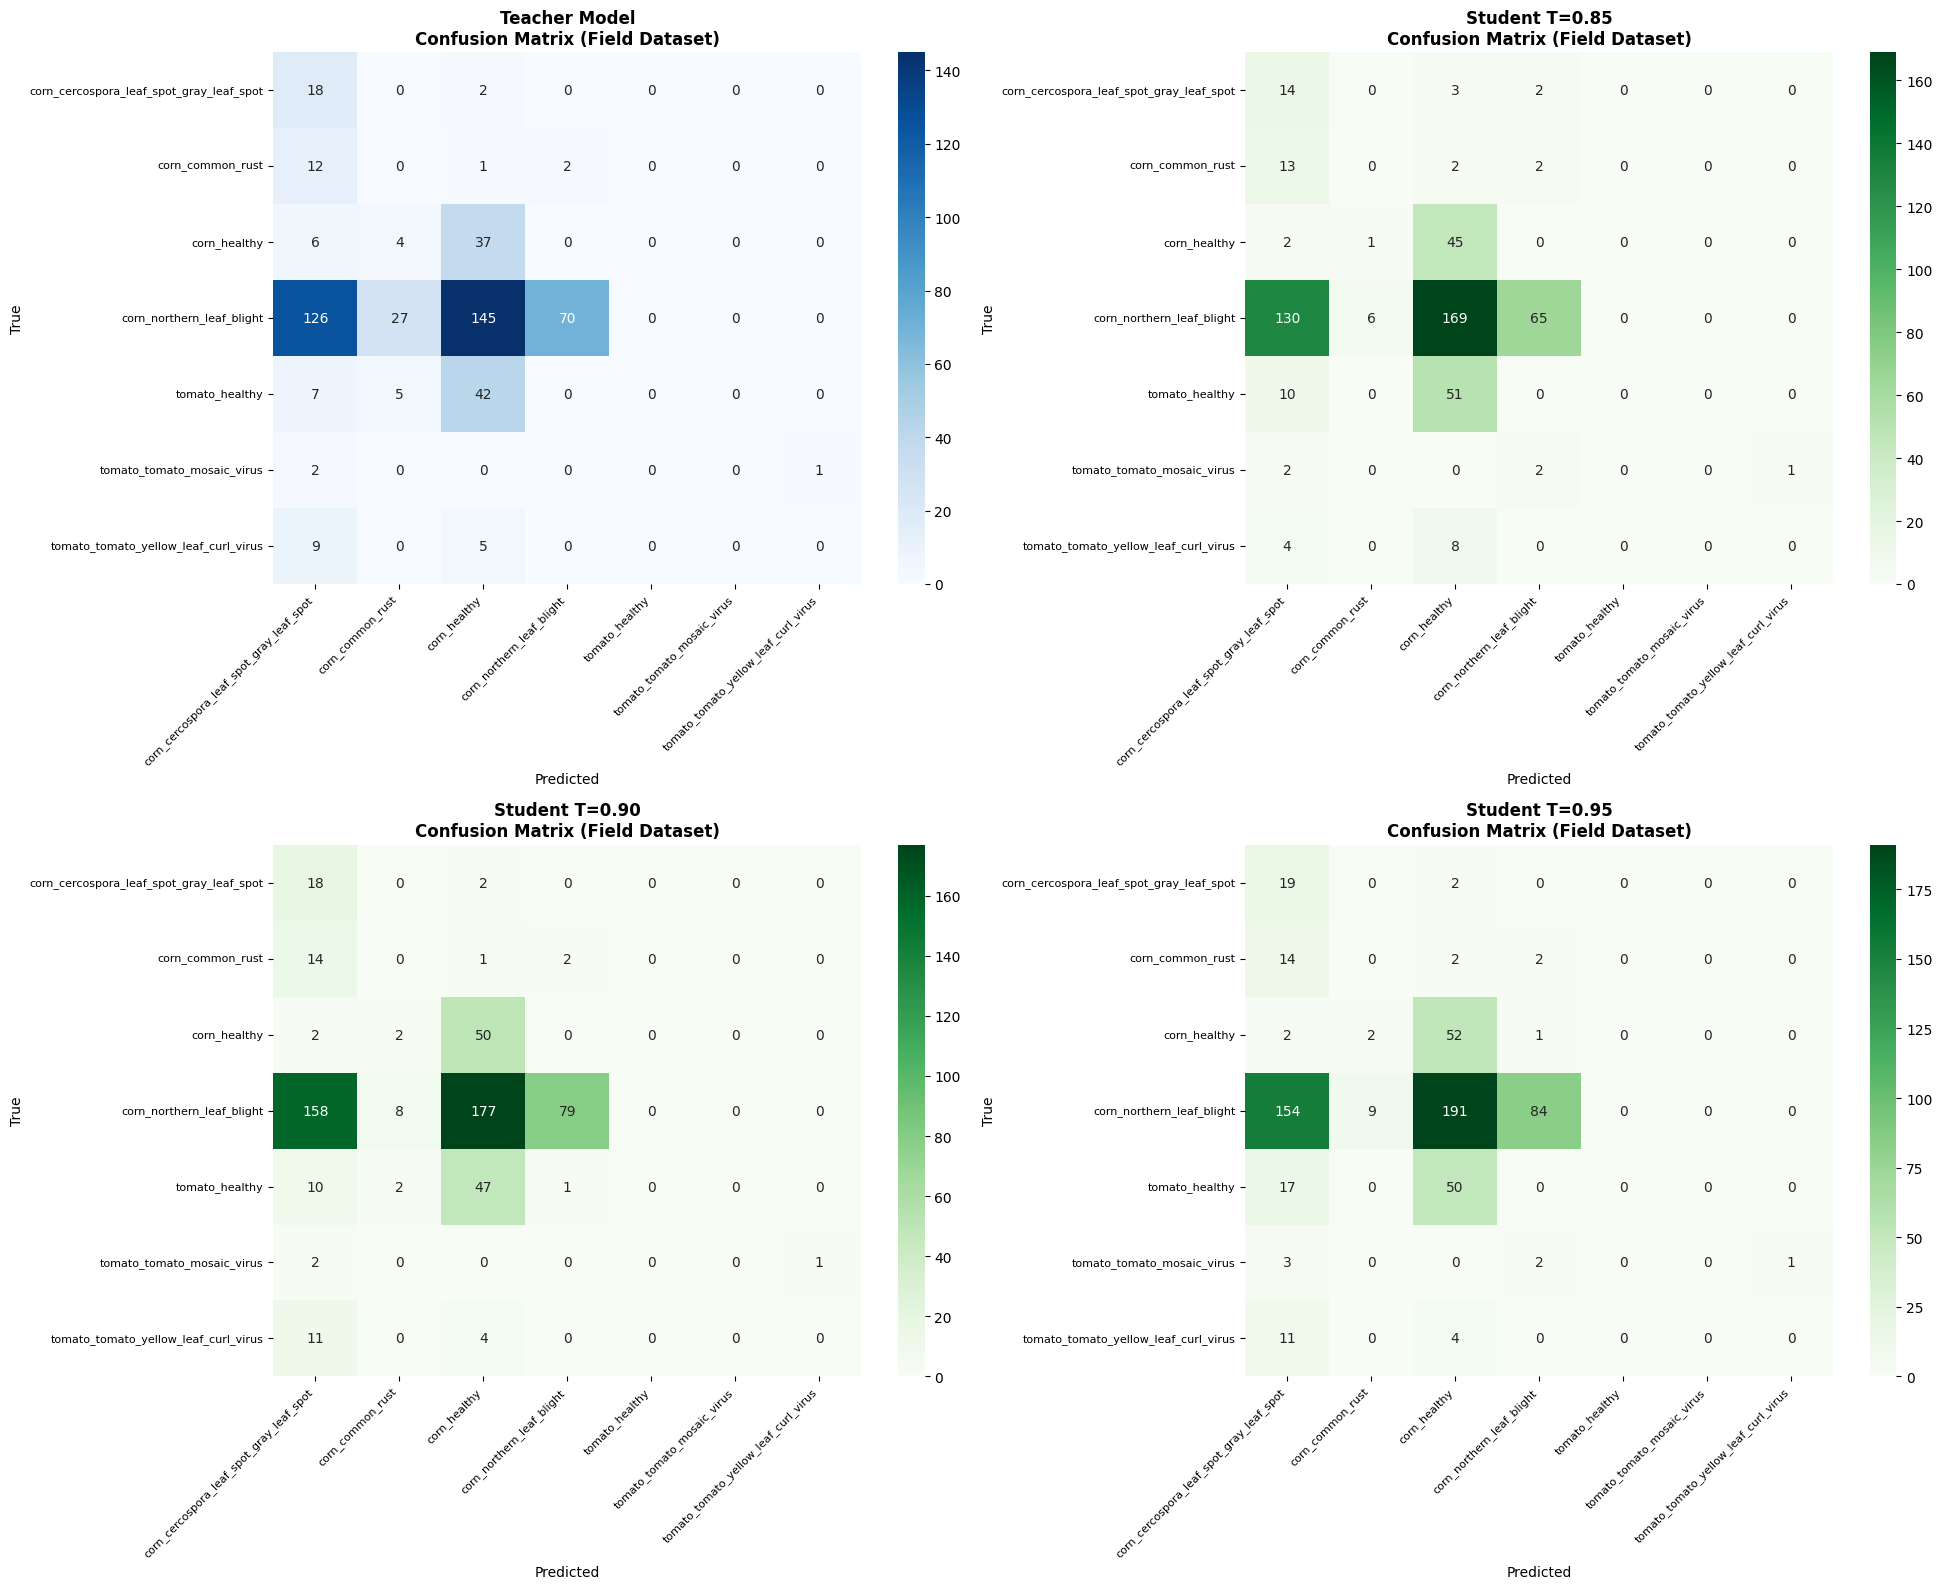

✓ Saved individual confusion matrices


In [16]:
# Generate confusion matrices for field dataset (all models)
intersection_class_ids = sorted([label_to_id[cls] for cls in intersection_classes])
intersection_class_names = [id_to_label[cid] for cid in intersection_class_ids]

# Teacher confusion matrix
cm_teacher = results_teacher_field['confusion_matrix']
cm_teacher_filtered = cm_teacher[np.ix_(intersection_class_ids, intersection_class_ids)]

# Student confusion matrices
confusion_matrices = {"teacher": cm_teacher_filtered}
for threshold in all_thresholds:
    cm_student = results_students_field[threshold]['confusion_matrix']
    cm_student_filtered = cm_student[np.ix_(intersection_class_ids, intersection_class_ids)]
    confusion_matrices[f"student_T{int(threshold*100):03d}"] = cm_student_filtered

# Plot all confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Teacher
sns.heatmap(
    confusion_matrices["teacher"],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=intersection_class_names,
    yticklabels=intersection_class_names,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Teacher Model\nConfusion Matrix (Field Dataset)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Predicted', fontsize=10)
axes[0, 0].set_ylabel('True', fontsize=10)
plt.setp(axes[0, 0].get_xticklabels(), rotation=45, ha='right', fontsize=8)
plt.setp(axes[0, 0].get_yticklabels(), rotation=0, fontsize=8)

# Student models
plot_idx = 1
for threshold in sorted(all_thresholds):
    row = plot_idx // 2
    col = plot_idx % 2
    key = f"student_T{int(threshold*100):03d}"
    
    sns.heatmap(
        confusion_matrices[key],
        annot=True,
        fmt='d',
        cmap='Greens',
        xticklabels=intersection_class_names,
        yticklabels=intersection_class_names,
        ax=axes[row, col]
    )
    axes[row, col].set_title(f'Student T={threshold:.2f}\nConfusion Matrix (Field Dataset)', 
                            fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Predicted', fontsize=10)
    axes[row, col].set_ylabel('True', fontsize=10)
    plt.setp(axes[row, col].get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(axes[row, col].get_yticklabels(), rotation=0, fontsize=8)
    
    plot_idx += 1

plt.tight_layout()
cm_save_path = EXPERIMENT_DIR / "confusion_matrices_comparison.png"
plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved confusion matrices to: {cm_save_path}")
plt.show()

# Also save individual confusion matrices
for threshold in all_thresholds:
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    key = f"student_T{int(threshold*100):03d}"
    sns.heatmap(
        confusion_matrices[key],
        annot=True,
        fmt='d',
        cmap='Greens',
        xticklabels=intersection_class_names,
        yticklabels=intersection_class_names,
        ax=ax
    )
    ax.set_title(f'Student T={threshold:.2f} - Confusion Matrix (Field Dataset)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax.get_yticklabels(), rotation=0)
    plt.tight_layout()
    
    individual_path = EXPERIMENT_DIR / f"confusion_T{int(threshold*100):03d}.png"
    plt.savefig(individual_path, dpi=300, bbox_inches='tight')
    plt.close()

print(f"✓ Saved individual confusion matrices")


## Step 5: Generate Comprehensive Report with Threshold Ablation Analysis


In [17]:
# Generate comprehensive report
report_path = EXPERIMENT_DIR / "report.txt"

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("EXPERIMENT 5: THRESHOLD ABLATION REPORT\n")
    f.write("="*70 + "\n\n")
    
    f.write("OBJECTIVE\n")
    f.write("-" * 70 + "\n")
    f.write("Quantify how pseudo-label quality vs quantity affects domain adaptation.\n")
    f.write("Test whether relaxing confidence threshold improves rare/zero F1 classes.\n")
    f.write("Maintain PlantVillage performance while improving Field performance.\n\n")
    
    # Pseudo-label statistics
    f.write("1. PSEUDO-LABEL STATISTICS\n")
    f.write("-" * 70 + "\n")
    f.write(f"{'Threshold':<12} {'Retained':<12} {'Total':<12} {'Retention %':<15}\n")
    f.write("-" * 70 + "\n")
    
    for threshold in sorted(all_thresholds):
        stats = pseudo_label_stats[threshold]
        f.write(f"T={threshold:.2f}      {stats['kept']:<12} {stats['total']:<12} {stats['retention_rate']:<15.2f}\n")
    f.write("\n")
    
    # Per-class pseudo-label counts (focus on tomato classes)
    f.write("Per-Class Pseudo-Label Counts (Focus on Tomato Classes):\n")
    f.write("-" * 70 + "\n")
    
    tomato_classes = ["tomato_healthy", "tomato_tomato_mosaic_virus", "tomato_tomato_yellow_leaf_curl_virus"]
    all_classes_in_stats = set()
    for threshold in all_thresholds:
        class_counts = Counter(pl["pseudo_label"] for pl in pseudo_label_stats[threshold]["pseudo_labels"])
        all_classes_in_stats.update(class_counts.keys())
    
    # Header
    f.write(f"{'Class':<50}")
    for threshold in sorted(all_thresholds):
        f.write(f" T={threshold:.2f}")
    f.write("\n")
    f.write("-" * 70 + "\n")
    
    # Tomato classes first (target classes)
    for tomato_class in tomato_classes:
        if tomato_class in label_to_id:
            class_id = label_to_id[tomato_class]
            f.write(f"{tomato_class:<50}")
            for threshold in sorted(all_thresholds):
                class_counts = Counter(pl["pseudo_label"] for pl in pseudo_label_stats[threshold]["pseudo_labels"])
                count = class_counts.get(class_id, 0)
                f.write(f" {count:>7}")
            f.write("\n")
    
    f.write("\nOther classes in pseudo-labels:\n")
    for class_id in sorted(all_classes_in_stats):
        class_name = id_to_label[class_id]
        if class_name not in tomato_classes:
            f.write(f"{class_name:<50}")
            for threshold in sorted(all_thresholds):
                class_counts = Counter(pl["pseudo_label"] for pl in pseudo_label_stats[threshold]["pseudo_labels"])
                count = class_counts.get(class_id, 0)
                f.write(f" {count:>7}")
            f.write("\n")
    f.write("\n")
    
    # Performance comparison
    f.write("2. PERFORMANCE COMPARISON\n")
    f.write("-" * 70 + "\n")
    
    f.write("\nA) PlantVillage Test Set (All Classes):\n")
    f.write(f"{'Model':<20} {'Accuracy':<12} {'Macro F1':<12} {'Change from Teacher':<20}\n")
    f.write("-" * 70 + "\n")
    
    teacher_pv_f1 = results_teacher_pv['f1_macro']
    teacher_pv_acc = results_teacher_pv['accuracy']
    
    f.write(f"{'Teacher':<20} {teacher_pv_acc:<12.4f} {teacher_pv_f1:<12.4f} {'(baseline)':<20}\n")
    
    for threshold in sorted(all_thresholds):
        results_pv = results_students_pv[threshold]
        f1_change = results_pv['f1_macro'] - teacher_pv_f1
        acc_change = results_pv['accuracy'] - teacher_pv_acc
        f.write(f"Student T={threshold:.2f}    {results_pv['accuracy']:<12.4f} {results_pv['f1_macro']:<12.4f} "
                f"F1: {f1_change:+.4f}, Acc: {acc_change:+.4f}\n")
    f.write("\n")
    
    f.write("B) Field Test Set (Intersection Classes Only):\n")
    f.write(f"{'Model':<20} {'Accuracy':<12} {'Macro F1':<12} {'Change from Teacher':<20}\n")
    f.write("-" * 70 + "\n")
    
    teacher_field_f1 = results_teacher_field['f1_macro']
    teacher_field_acc = results_teacher_field['accuracy']
    
    f.write(f"{'Teacher':<20} {teacher_field_acc:<12.4f} {teacher_field_f1:<12.4f} {'(baseline)':<20}\n")
    
    best_field_f1 = teacher_field_f1
    best_threshold = None
    
    for threshold in sorted(all_thresholds):
        results_field = results_students_field[threshold]
        f1_change = results_field['f1_macro'] - teacher_field_f1
        acc_change = results_field['accuracy'] - teacher_field_acc
        
        if results_field['f1_macro'] > best_field_f1:
            best_field_f1 = results_field['f1_macro']
            best_threshold = threshold
        
        f.write(f"Student T={threshold:.2f}    {results_field['accuracy']:<12.4f} {results_field['f1_macro']:<12.4f} "
                f"F1: {f1_change:+.4f}, Acc: {acc_change:+.4f}\n")
    f.write("\n")
    
    # Per-class F1 for target tomato classes
    f.write("C) Per-Class F1 Scores for Target Rare Classes (Field Test Set):\n")
    f.write("-" * 70 + "\n")
    f.write(f"{'Class':<50} {'Teacher':<12}")
    for threshold in sorted(all_thresholds):
        f.write(f" T={threshold:.2f}")
    f.write("\n")
    f.write("-" * 70 + "\n")
    
    for tomato_class in tomato_classes:
        if tomato_class in label_to_id:
            class_id = label_to_id[tomato_class]
            teacher_f1 = results_teacher_field['per_class_f1'].get(tomato_class, 0.0)
            f.write(f"{tomato_class:<50} {teacher_f1:<12.4f}")
            for threshold in sorted(all_thresholds):
                student_f1 = results_students_field[threshold]['per_class_f1'].get(tomato_class, 0.0)
                improvement = "✓" if student_f1 > teacher_f1 and teacher_f1 == 0.0 else ""
                f.write(f" {student_f1:>7.4f}{improvement}")
            f.write("\n")
    
    f.write("\nAll intersection classes:\n")
    for class_id in sorted(intersection_class_ids):
        class_name = id_to_label[class_id]
        teacher_f1 = results_teacher_field['per_class_f1'].get(class_name, 0.0)
        f.write(f"{class_name:<50} {teacher_f1:<12.4f}")
        for threshold in sorted(all_thresholds):
            student_f1 = results_students_field[threshold]['per_class_f1'].get(class_name, 0.0)
            f.write(f" {student_f1:>7.4f}")
        f.write("\n")
    f.write("\n")
    
    # Analysis and interpretation
    f.write("3. ANALYSIS AND INTERPRETATION\n")
    f.write("-" * 70 + "\n")
    
    # Find best threshold
    field_improvements = {}
    for threshold in all_thresholds:
        field_f1 = results_students_field[threshold]['f1_macro']
        pv_f1 = results_students_pv[threshold]['f1_macro']
        field_improvement = field_f1 - teacher_field_f1
        pv_change = pv_f1 - teacher_pv_f1
        
        field_improvements[threshold] = {
            "field_f1": field_f1,
            "field_improvement": field_improvement,
            "pv_f1": pv_f1,
            "pv_change": pv_change,
            "pv_drop": abs(pv_change)
        }
    
    # Primary success: Field Macro-F1 improves over Teacher and over T=0.90
    f.write("\nPrimary Success Criterion: Field Macro-F1 improves over Teacher AND over T=0.90\n")
    reference_T090_field = results_students_field[0.90]['f1_macro']
    
    for threshold in sorted(all_thresholds):
        if threshold == 0.90:
            continue
        stats = field_improvements[threshold]
        improves_over_teacher = stats["field_improvement"] > 0
        improves_over_T090 = stats["field_f1"] > reference_T090_field
        
        if improves_over_teacher and improves_over_T090:
            f.write(f"  ✓ T={threshold:.2f}: Field F1 improves over Teacher (+{stats['field_improvement']:.4f}) "
                   f"AND over T=0.90 (+{stats['field_f1'] - reference_T090_field:.4f})\n")
        elif improves_over_teacher:
            f.write(f"  → T={threshold:.2f}: Field F1 improves over Teacher (+{stats['field_improvement']:.4f}) "
                   f"but not over T=0.90 ({stats['field_f1'] - reference_T090_field:.4f})\n")
        else:
            f.write(f"  ✗ T={threshold:.2f}: Field F1 does not improve over Teacher ({stats['field_improvement']:.4f})\n")
    
    # Secondary success: At least one tomato class moves from F1=0 → F1>0
    f.write("\nSecondary Success Criterion: At least one tomato class moves from F1=0 → F1>0\n")
    for threshold in sorted(all_thresholds):
        tomato_improvements = []
        for tomato_class in tomato_classes:
            if tomato_class in label_to_id:
                teacher_f1 = results_teacher_field['per_class_f1'].get(tomato_class, 0.0)
                student_f1 = results_students_field[threshold]['per_class_f1'].get(tomato_class, 0.0)
                if teacher_f1 == 0.0 and student_f1 > 0.0:
                    tomato_improvements.append(tomato_class)
        
        if tomato_improvements:
            f.write(f"  ✓ T={threshold:.2f}: {len(tomato_improvements)} tomato class(es) improved from 0: {', '.join(tomato_improvements)}\n")
        else:
            f.write(f"  ✗ T={threshold:.2f}: No tomato classes improved from F1=0\n")
    
    # Guardrail: PV Macro-F1 drop must be ≤ 0.01 absolute
    f.write("\nGuardrail: PV Macro-F1 drop must be ≤ 0.01 absolute\n")
    for threshold in sorted(all_thresholds):
        stats = field_improvements[threshold]
        if stats["pv_drop"] <= 0.01:
            f.write(f"  ✓ T={threshold:.2f}: PV F1 change = {stats['pv_change']:+.4f} (acceptable)\n")
        else:
            f.write(f"  ✗ T={threshold:.2f}: PV F1 change = {stats['pv_change']:+.4f} (exceeds 0.01 threshold)\n")
    
    # Expected interpretation
    f.write("\n4. EXPECTED INTERPRETATION\n")
    f.write("-" * 70 + "\n")
    
    # Determine best threshold
    valid_thresholds = [t for t in all_thresholds 
                       if field_improvements[t]["field_improvement"] > 0 
                       and field_improvements[t]["pv_drop"] <= 0.01]
    
    if valid_thresholds:
        best_valid = max(valid_thresholds, key=lambda t: field_improvements[t]["field_f1"])
        f.write(f"\nBest Threshold: T={best_valid:.2f}\n")
        
        if best_valid == 0.95:
            f.write("Interpretation: T=0.95 best → Pseudo-label noise is harmful; quality dominates.\n")
            f.write("Higher confidence threshold reduces noise, leading to better adaptation.\n")
        elif best_valid == 0.85:
            f.write("Interpretation: T=0.85 best → Coverage dominates; more field data helps even if noisier.\n")
            f.write("Additional pseudo-labeled samples provide sufficient signal despite noise.\n")
        else:
            f.write("Interpretation: T=0.90 (middle ground) is optimal.\n")
            f.write("Balanced trade-off between quality and quantity.\n")
    else:
        f.write("\nNo threshold meets all success criteria.\n")
        if best_threshold is not None:
            f.write(f"Best Field F1 achieved at T={best_threshold:.2f}, but fails guardrail or other criteria.\n")
        f.write("Interpretation: Pseudo-label noise overwhelms benefits.\n")
        f.write("Recommendation: Need better teacher model or per-class thresholds.\n")
    
    # Summary table
    f.write("\n5. SUMMARY TABLE\n")
    f.write("-" * 70 + "\n")
    f.write(f"{'Threshold':<12} {'Retention %':<15} {'PV F1':<12} {'Field F1':<12} {'Field Δ':<12} {'PV Δ':<12} {'Status':<20}\n")
    f.write("-" * 70 + "\n")
    
    f.write(f"{'Teacher':<12} {'N/A':<15} {teacher_pv_f1:<12.4f} {teacher_field_f1:<12.4f} "
           f"{'0.0000':<12} {'0.0000':<12} {'baseline':<20}\n")
    
    for threshold in sorted(all_thresholds):
        stats = field_improvements[threshold]
        pseudo_stats = pseudo_label_stats[threshold]
        status = ""
        if stats["field_improvement"] > 0 and stats["pv_drop"] <= 0.01:
            status = "SUCCESS"
        elif stats["pv_drop"] > 0.01:
            status = "FAIL (PV drop)"
        elif stats["field_improvement"] <= 0:
            status = "FAIL (no improve)"
        else:
            status = "PARTIAL"
        
        f.write(f"T={threshold:.2f}     {pseudo_stats['retention_rate']:<15.2f} {stats['pv_f1']:<12.4f} "
               f"{stats['field_f1']:<12.4f} {stats['field_improvement']:+.4f}     "
               f"{stats['pv_change']:+.4f}     {status:<20}\n")
    
    f.write("\n6. FILES GENERATED\n")
    f.write("-" * 70 + "\n")
    for threshold in sorted(all_thresholds):
        if threshold != 0.90 or not USE_EXISTING_STUDENT_T090:
            model_path = MODELS_DIR / f"efficientnet_b0_student_T{int(threshold*100):03d}.pt"
            f.write(f"  - student_T{int(threshold*100):03d}.pt: {model_path}\n")
        else:
            f.write(f"  - student_T090.pt: (from Experiment 4)\n")
        csv_path = EXPERIMENT_DIR / f"pseudo_labeled_field_T{int(threshold*100):03d}.csv"
        if csv_path.exists():
            f.write(f"  - pseudo_labeled_field_T{int(threshold*100):03d}.csv: {csv_path}\n")
    f.write(f"  - confusion_matrices_comparison.png: {cm_save_path}\n")
    f.write(f"  - confusion_T095.png, confusion_T090.png, confusion_T085.png: {EXPERIMENT_DIR}\n")
    f.write(f"  - report.txt: {report_path}\n")

print(f"\n✓ Comprehensive report saved to: {report_path}")

# Print summary to console
print("\n" + "="*70)
print("EXPERIMENT 5: THRESHOLD ABLATION SUMMARY")
print("="*70)

print("\nPseudo-Label Statistics:")
print(f"{'Threshold':<12} {'Retained':<12} {'Retention %':<15}")
print("-" * 40)
for threshold in sorted(all_thresholds):
    stats = pseudo_label_stats[threshold]
    print(f"T={threshold:.2f}      {stats['kept']:<12} {stats['retention_rate']:<15.2f}")

print("\nPerformance Comparison (Field Test Set):")
print(f"{'Model':<20} {'Field F1':<12} {'Improvement':<15}")
print("-" * 50)
print(f"{'Teacher':<20} {teacher_field_f1:<12.4f} {'(baseline)':<15}")
for threshold in sorted(all_thresholds):
    field_f1 = results_students_field[threshold]['f1_macro']
    improvement = field_f1 - teacher_field_f1
    print(f"Student T={threshold:.2f}    {field_f1:<12.4f} {improvement:+.4f}     ")

# Tomato classes improvement
print("\nTomato Classes (Target Rare Classes) - F1 Scores:")
for tomato_class in tomato_classes:
    if tomato_class in label_to_id:
        teacher_f1 = results_teacher_field['per_class_f1'].get(tomato_class, 0.0)
        print(f"\n  {tomato_class}:")
        print(f"    Teacher: {teacher_f1:.4f}")
        for threshold in sorted(all_thresholds):
            student_f1 = results_students_field[threshold]['per_class_f1'].get(tomato_class, 0.0)
            change = student_f1 - teacher_f1
            marker = "✓" if teacher_f1 == 0.0 and student_f1 > 0.0 else ""
            print(f"    T={threshold:.2f}: {student_f1:.4f} ({change:+.4f}) {marker}")

print("\n" + "="*70)



✓ Comprehensive report saved to: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_5_threshold_ablation\report.txt

EXPERIMENT 5: THRESHOLD ABLATION SUMMARY

Pseudo-Label Statistics:
Threshold    Retained     Retention %    
----------------------------------------
T=0.85      2046         55.12          
T=0.90      1819         49.00          
T=0.95      1445         38.93          

Performance Comparison (Field Test Set):
Model                Field F1     Improvement    
--------------------------------------------------
Teacher              0.0307       (baseline)     
Student T=0.85    0.0304       -0.0003     
Student T=0.90    0.0342       +0.0035     
Student T=0.95    0.0348       +0.0041     

Tomato Classes (Target Rare Classes) - F1 Scores:

  tomato_healthy:
    Teacher: 0.0000
    T=0.85: 0.0000 (+0.0000) 
    T=0.90: 0.0000 (+0.0000) 
    T=0.95: 0.0000 (+0.0000) 

  tomato_tomato_mosaic_virus:
    Teacher: 0.0000
    T=0.85: 0.0000 (+0.0000) 
   